# Qiskit VQE チュートリアル (Jupyter Notebook版)
このノートブックは、Qiskitの変分量子固有値ソルバー（VQE）のチュートリアルを対話的に実行できるようにしたものです。
以下の２つのチュートリアルをまとめ、エラーなく動くようにし、最終的に日本語化したものです。（Qikitのバージョンは一旦v1.xにしています。最近のv2.xだと動かない可能性あり）
- https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/01_algorithms_introduction.ipynb
- https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/02_vqe_advanced_options.ipynb

## Qiskitにおけるアルゴリズムの概要
このセクションでは、Qiskitのアルゴリズム機能の全体像と、それらがどのように構成されているかについて説明します。

### アルゴリズムライブラリの構造
Qiskitは多数のアルゴリズムを提供しており、それらは実行可能なタスクに応じてカテゴリ別にグループ化されています。主要なカテゴリには以下のようなものがあります。

- 最小固有値ソルバー (Minimum Eigensolvers):
演算子の最小固有値を求めるためのアルゴリズム群です。例えば、化学ハミルトニアンの基底状態エネルギー（分子の最も安定なエネルギー状態）の計算や、イジングハミルトニアンとして表現された組み合わせ最適化問題の解を求めるのに使われます。このチュートリアルで中心的に扱うVQE（Variational Quantum Eigensolver）もこのカテゴリに含まれます。

- 時間発展ソルバー (Time Evolvers):
量子系の時間発展をシミュレートするためのアルゴリズムです。シュレーディンガー方程式に基づいて量子状態が時間とともにどのように変化するかを計算します。

- 振幅推定アルゴリズム (Amplitude Estimators):
特定の量子状態の振幅を推定するためのアルゴリズムです。これは、金融アプリケーションにおけるリスク分析やオプション価格設定など、確率的な事象の評価に応用できます。

これらのアルゴリズムは設定可能であり、多くの場合、設定の一部はより小さな構成要素（ビルディングブロック）の形で提供されます。これにより、ユーザーは異なる種類のビルディングブロックの異なるインスタンスを柔軟に組み合わせて、特定のタスクやハードウェアに最適化されたアルゴリズムを構築できます。

例えば、VQE (変分量子固有値ソルバー) を考えてみましょう。VQEは以下の主要な構成要素を取ります。

- Ansatz (試行波動関数): パラメータ化された量子回路で、そのパラメータを調整することで様々な量子状態を表現します。VQEの目標は、このAnsatzが表現する量子状態の中で、与えられたハミルトニアンの期待値を最小にする（つまり基底状態に最も近くなる）ようにパラメータを最適化することです。

- 古典的オプティマイザ: Ansatzのパラメータを更新し、ハミルトニアンの期待値（コスト関数）を最小化するための古典的な最適化アルゴリズムです。勾配ベースの手法（例: SPSA, L-BFGS-B）や勾配フリーの手法（例: COBYLA, SLSQP）など、様々なオプティマイザが利用可能です。

- Estimator (Qiskit Primitive): Ansatz回路とハミルトニアンから期待値を計算するための基本要素です。シミュレータ（ノイズなし、ノイズあり）や実量子デバイス上で実行できます。

これらの構成要素を個別のインスタンスとして作成し、VQEアルゴリズムを構築する際に渡します。例えば、異なる古典的オプティマイザや異なるAnsatzを試したい場合、対応するインスタンスを作成し、VQEに渡すだけで簡単に実験できます。

## 0. ライブラリのインポートと設定
まず、必要なライブラリをインポートし、プロット設定を行います。

In [3]:

%matplotlib inline

# 数値計算ライブラリ
import numpy as np

# プロット用ライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語対応のため

# IPython.displayからdisplayをインポート (Jupyter Notebookでオブジェクトをリッチに表示するため)
from IPython.display import display

# Qiskitの主要コンポーネント (qiskit_algorithms を使用)
# qiskit_algorithmsは、Qiskitのアルゴリズム機能を提供するパッケージ
# VQEやNumPyMinimumEigensolverなどの最小固有値ソルバーが含まれる
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
# SLSQP, SPSAなどの古典的オプティマイザ
from qiskit_algorithms.optimizers import SLSQP, SPSA, COBYLA, L_BFGS_B
# 有限差分法などによる勾配計算のためのクラス
from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient

# Qiskitのコアコンポーネント
# TwoLocalなどの標準的なAnsatz回路
from qiskit.circuit.library import TwoLocal
# SparsePauliOpなど、量子演算子を表現するためのクラス
from qiskit.quantum_info import SparsePauliOp
# EstimatorなどのQiskit Primitives (期待値計算やサンプリングの基本機能)
from qiskit.primitives import Estimator


## 1. VQEの準備
VQEアルゴリズムの基本的な構成要素であるAnsatz（試行波動関数）と古典的オプティマイザを準備します。

--- 1. VQEの準備 ---
Ansatz (TwoLocal) と Optimizer (SLSQP) を準備しました。

Ansatzの構造 (Matplotlib描画):


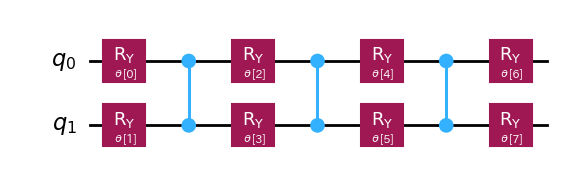

------------------------------



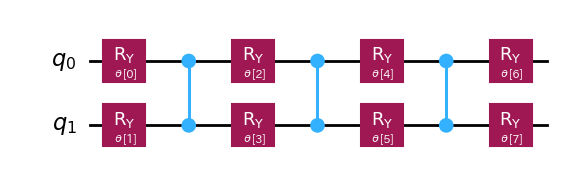

In [4]:
print("--- 1. VQEの準備 ---")
num_qubits = 2 # この例で使用する量子ビット数

# Ansatz (試行波動関数) の定義
# TwoLocalは、回転ゲート層とエンタングルメントゲート層を交互に繰り返す、一般的で柔軟なAnsatzです。
# ここでは、2量子ビットに対して、回転ゲートとして'ry'（Y軸回転）、
# エンタングルメントブロックとして'cz'（Controlled-Zゲート）を使用します。
ansatz = TwoLocal(num_qubits, 'ry', 'cz')

# 古典的オプティマイザの定義
# SLSQP (Sequential Least Squares Programming) は、制約付き最適化問題にも対応できる勾配ベースのオプティマイザです。
# maxiterは最大イテレーション（繰り返し）回数を指定します。
optimizer_slsqp = SLSQP(maxiter=1000)

print(f"Ansatz ({type(ansatz).__name__}) と Optimizer ({type(optimizer_slsqp).__name__}) を準備しました。")

# Ansatzの回路構造を描画 (オプション)
# このAnsatzは量子回路であり、θ[0]からθ[7]までのパラメータ（回転角など）を持ちます。
# VQEの最適化プロセスでは、これらのパラメータが調整され、最小固有値が見つけられます。
# パラメータについては、後の具体的な実行例で再度触れます。
try:
    print("\nAnsatzの構造 (Matplotlib描画):")
    # 'mpl' バックエンドを使用。pylatexenc が必要。
    # decompose()メソッドは、Ansatzを基本ゲートに分解してから描画します。
    display(ansatz.decompose().draw('mpl'))
except ImportError as e:
    if 'pylatexenc' in str(e).lower():
        print(f"描画エラー: {e}")
        print("Matplotlibバックエンドでの描画には 'pylatexenc' ライブラリが必要です。")
        print("ノートブックの最初のセルで '!pip install pylatexenc' を実行し、カーネルを再起動してください。")
    else:
        print(f"Ansatzの描画中に予期せぬImportErrorが発生しました: {e}")
except Exception as e:
    print(f"Ansatzの描画中にエラーが発生しました: {e}")
    print("描画をスキップします。")
print("-" * 30 + "\n")



## 2. Estimatorの準備とVQEインスタンスの作成
期待値計算のためのEstimatorプリミティブを準備し、VQEインスタンスを作成します。

### アルゴリズムの実行方法：Qiskit Primitivesの役割
Qiskitのアルゴリズムは、量子回路の期待値評価やサンプリングを行うために プリミティブ (Primitives) と呼ばれる基本インターフェースに依存しています。プリミティブには主に以下の2種類があります。

Estimator: 量子回路と観測量の組（オブザーバブル）を入力とし、そのオブザーバブルの期待値を計算します。VQEのようにエネルギー（ハミルトニアンの期待値）を計算する必要がある場合に用います。

Sampler: 量子回路を入力とし、その出力の確率分布からビット文字列をサンプリングします。

これらのプリミティブは、バックエンド（シミュレータや実量子デバイス）に基づいており、同じインターフェースを実装しているため、アルゴリズム内で相互に交換可能です。これにより、例えば最初にシミュレータでアルゴリズムをテストし、その後、同じアルゴリズムコードを実デバイス用に変更することが容易になります。

VQEでは期待値を評価する必要があるため、Estimator を使用します。Qiskit Terraのデフォルトインストールには、参照用の Estimator が含まれています

In [5]:
print("--- 2. Estimatorの準備 ---")
# Estimatorのインスタンス化
# このEstimatorは、期待値を評価するために正確な状態ベクトルシミュレーションを使用します。
# オプションを指定することで、ショットベースのシミュレーション（測定回数を指定）や
# ノイズモデルを組み込んだシミュレーションも可能です。
# シミュレータの詳細はQiskit Aer、実機ハードウェアについてはQiskit IBM Runtimeを参照してください。
estimator = Estimator()
print(f"Estimator ({type(estimator).__name__}) を準備しました。")
print("-" * 30 + "\n")

# VQEインスタンスの作成
# これで、Estimator、Ansatz、OptimizerというVQEの主要な構成要素が揃いました。
# これらを引数としてVQEのインスタンスを作成します。
# (qiskit_algorithmsのVQEを使用)
vqe = VQE(estimator, ansatz, optimizer_slsqp)
print(f"VQEインスタンス ({type(vqe).__name__}) を作成しました。")
print("-" * 30 + "\n")


--- 2. Estimatorの準備 ---
Estimator (Estimator) を準備しました。
------------------------------

VQEインスタンス (VQE) を作成しました。
------------------------------



VQEインスタンスが作成できたら、compute_minimum_eigenvalue() メソッドを呼び出して最小固有値を計算できます。このメソッドは、例えばQiskit Nature（量子化学計算）やQiskit Optimization（最適化問題）のようなアプリケーションモジュールが、特定のアルゴリズムカテゴリ（この場合は最小固有値ソルバー）内の任意のアルゴリズムと互換的に動作できるようにするための標準的なインターフェースです。

## 3. 完全な動作例：H2分子のVQE計算
これまでに学んだことをまとめて、完全な動作例を作成しましょう。VQEはハミルトニアン演算子の最小固有値、つまり最小エネルギー値を求めます。そのため、VQEが動作するためのハミルトニアン演算子が必要です。

以下に示すのは、Qiskit Natureアプリケーションモジュールによって元々作成された、原子間距離0.735ÅにおけるH2（水素）分子のハミルトニアンです。これはパウリ項の合計として表されます（例: "II", "IZ", "ZI", "ZZ", "XX" はパウリ演算子または恒等演算子を表し、それぞれに係数が付きます）。ここでは、このハミルトニアンの詳細には立ち入らず、アルゴリズムを実行することに焦点を当てます。演算子の詳細については、他のチュートリアルを参照してください。

In [6]:
print("--- 3. H2分子のVQE計算 ---")
# H2分子のハミルトニアン演算子 (原子間距離 0.735Å)
# SparsePauliOp形式で定義
H2_op = SparsePauliOp.from_list([
    ("II", -1.052373245772859), # 第1量子ビットにI、第0量子ビットにI
    ("IZ", 0.39793742484318045), # 第1量子ビットにI、第0量子ビットにZ
    ("ZI", -0.39793742484318045), # 第1量子ビットにZ、第0量子ビットにI
    ("ZZ", -0.01128010425623538), # 第1量子ビットにZ、第0量子ビットにZ
    ("XX", 0.18093119978423156)  # 第1量子ビットにX、第0量子ビットにX
])
print("H2分子のハミルトニアン (SparsePauliOp):")
print(H2_op.to_list()) # ハミルトニアンのリスト形式での表示

# VQE計算の実行
# vqeインスタンスのcompute_minimum_eigenvalueメソッドにハミルトニアン演算子を渡します。
result = vqe.compute_minimum_eigenvalue(H2_op)
print("\nVQE計算結果:")
# 結果オブジェクトには多くの情報が含まれています。
# 'eigenvalue' が求めたい最小固有値（この場合はH2分子の基底状態エネルギー）です。
print(f"  固有値 (エネルギー): {result.eigenvalue.real:.8f}")
# 'optimal_point' は、最小固有値を与えたAnsatzの最適パラメータのリストです。
print(f"  最適パラメータ: {result.optimal_point}")
# 'optimal_parameters' は、最適パラメータをパラメータオブジェクトと値の辞書として保持します。
# 'cost_function_evals' は、オプティマイザがコスト関数（エネルギー）を評価した回数です。
print(f"  コスト関数評価回数: {result.cost_function_evals}")
# 'optimal_circuit' は最適パラメータが設定されたAnsatz回路です。
# 'optimizer_time' は最適化にかかった時間です。

print("-" * 30 + "\n")
# print("\n詳細な結果オブジェクト:")
# print(result) # 全ての結果情報を表示したい場合
# print("-" * 30 + "\n")



--- 3. H2分子のVQE計算 ---
H2分子のハミルトニアン (SparsePauliOp):
[('II', (-1.052373245772859+0j)), ('IZ', (0.39793742484318045+0j)), ('ZI', (-0.39793742484318045+0j)), ('ZZ', (-0.01128010425623538+0j)), ('XX', (0.18093119978423156+0j))]

VQE計算結果:
  固有値 (エネルギー): -1.85727489
  最適パラメータ: [ 0.94919678 -3.57004629  6.06914937 -0.62269984  1.85308961  2.2381097
  5.62816293  4.66414088]
  コスト関数評価回数: 54
------------------------------



上記の結果から、オプティマイザがコスト関数（エネルギー）を評価した回数（例: cost_function_evals）や、見つかった最小固有値（H2分子の電子基底状態エネルギーである約-1.857）がわかります。また、最小エネルギー値におけるAnsatzの最適パラメータ（optimal_parameters や optimal_point）も確認できます。

### 3.1. VQE内のプリミティブの更新 (ショットベースEstimatorとSPSA)
シミュレーション結果に満足し、次にショットベースのシミュレータを使用したり、実デバイスで実行したりしたい場合もあるでしょう。VQE内で使用するEstimatorプリミティブを変更する方法を見てみましょう。

この例では、Estimatorをショットベースのものに変更します。これは、実際の量子コンピュータのように、量子回路を何回も実行（ショット）し、その測定結果から期待値を推定する方法です。Qiskit Terraの参照プリミティブを引き続き使用しますが、Estimator のオプションでショット数を指定します。
このプリミティブは、例えばQiskit Aerの Estimator (qiskit_aer.primitives.Estimator) や、実際のバックエンド (qiskit_ibm_runtime.Estimator) などに置き換えることも可能です。

ノイズの多いコスト関数（例えば、ショットノイズが含まれる場合）に対しては、SPSA (Simultaneous Perturbation Stochastic Approximation) オプティマイザが一般的に良好な性能を発揮するとされています。そのため、オプティマイザもSPSAに変更します。ショットベースおよびノイズありシミュレーションの詳細については、「ノイズありVQEチュートリアル」なども参照してください。

In [47]:
print("--- 3.1. VQE内のプリミティブの更新 (ショットベースEstimatorとSPSA) ---")
# ショットベースのEstimator (シミュレーション回数を指定)
# options={"shots": 1024} により、各期待値計算で1024回のショット測定が行われます。
estimator_shots = Estimator(options={"shots": 1024})

# SPSAオプティマイザ (qiskit_algorithms.optimizersを使用)
# SPSAは、各イテレーションで2回のコスト関数評価のみで勾配を近似するため、評価回数が多い場合に効率的です。
optimizer_spsa = SPSA(maxiter=100)

# 再現性のためにシードを設定 (SPSAは確率的な要素を含むため)
# NumPyのグローバル乱数ジェネレータにシードを設定します。
np.random.seed(42)

# Ansatzも新しいものを使うか、パラメータをリセットする必要がある場合がある
# 前のVQE実行でansatzインスタンスの内部状態が変わっている可能性があるため、
# 新しい計算では新しいインスタンスを使用するのが安全です。
ansatz_for_spsa = TwoLocal(num_qubits, 'ry', 'cz')

# 新しい設定でVQEインスタンスを作成 (qiskit_algorithmsのVQEを使用)
# estimatorとoptimizerを新しいものに置き換えます。ansatzも新しいインスタンスを使用。
vqe_shots_spsa = VQE(estimator_shots, ansatz_for_spsa, optimizer_spsa)

print("\nVQE計算を実行中 (ショットベースEstimator, SPSA)...")
result_shots = vqe_shots_spsa.compute_minimum_eigenvalue(operator=H2_op)
print("\nVQE計算結果 (ショットベース, SPSA):")
print(f"  固有値 (エネルギー): {result_shots.eigenvalue.real:.8f}")
print(f"  最適パラメータ: {result_shots.optimal_point}")
print(f"  コスト関数評価回数: {result_shots.cost_function_evals}")
print("-" * 30 + "\n")


--- 3.1. VQE内のプリミティブの更新 (ショットベースEstimatorとSPSA) ---

VQE計算を実行中 (ショットベースEstimator, SPSA)...

VQE計算結果 (ショットベース, SPSA):
  固有値 (エネルギー): -1.85664023
  最適パラメータ: [ 2.91064973 -3.21671253  5.4138368  -2.63539274  5.58414972 -2.54142099
  4.99662276 -3.44101931]
  コスト関数評価回数: 200
------------------------------



これで、Qiskitにおけるアルゴリズムの基本的な導入は終わりです。より広範な、またより詳細なアルゴリズムの解説については、このシリーズの他のアルゴリズムチュートリアルも参照してください。

## 4. VQEの高度なオプション
基本的なVQEアルゴリズムの設定方法を学んだところで、次にQiskitの変分アルゴリズム（VQE、QAOA、VQDなど）の全機能を探索するための、より高度な設定パラメータを見ていきましょう。特に、収束を監視するためのコールバック (Callback) の設定、カスタム初期値 (Initial points) および勾配 (Gradients) の使用について説明します。

### 4.1. コールバック関数による最適化プロセスの監視
コールバックメソッドを使用すると、アルゴリズムの実行中に最適化の進捗をリアルタイムで監視し、最小値への収束を確認できます。コールバック関数は、オプティマイザによる各関数評価（コスト関数の計算）の際に呼び出され、現在の評価回数、パラメータ値、コスト関数の平均値、標準偏差（もしあれば）などを提供します。

注意点として、オプティマイザによっては、コールバックが呼び出されるタイミングがオプティマイザの各イテレーション（ステップ）と一致しない場合があります。例えば、オプティマイザが有限差分法に基づいて勾配を計算するためにコスト関数を複数回呼び出す場合、それらの呼び出しもコールバックを通じて観測できます。

このセクションでは、VQEでコールバックを活用して、選択したいくつかのオプティマイザでの基底状態エネルギーへの収束経路をプロットする方法を示します。
使用するハミルトニアンは、これまでの例と同じH2分子のものです。Estimatorも同様に、Qiskit Terraに同梱されているデフォルトの Estimator を使用します。

In [55]:
print("--- 4.1. コールバック関数による最適化プロセスの監視 ---")
# 比較するオプティマイザのリスト (qiskit_algorithms.optimizers を使用)
# COBYLA: 勾配を用いないオプティマイザ
# L_BFGS_B: 勾配を用いるオプティマイザ（勾配が提供されない場合は有限差分で近似）
# SLSQP: 勾配を用いるオプティマイザ（同様に有限差分で近似可能）
optimizers_for_cb = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]

# 各オプティマイザの収束データを格納するリスト
converge_counts_list = [] # 評価回数のリストを格納
converge_vals_list = []  # エネルギー値のリストを格納
optimizer_names = []     # オプティマイザ名のリスト

# H2_op と estimator (デフォルトの厳密なもの) は前のセルで定義済み
# num_qubits も定義済み

print("\n各オプティマイザでVQEを実行し、コールバックデータを収集します...")

# ループやVQEのランダムな初期値選択の再現性のため
# (VQEがinitial_pointなしで実行される場合、ランダムな初期パラメータが使われることがあるため)
np.random.seed(50)

for i, optimizer_instance in enumerate(optimizers_for_cb):
    optimizer_name = type(optimizer_instance).__name__
    optimizer_names.append(optimizer_name)
    print(f"\rOptimizer: {optimizer_name}        ", end="") # \rで同じ行に進捗を表示

    # 各試行で新しいAnsatzインスタンスを作成 (パラメータが前の試行の影響を受けないようにするため)
    ansatz_cb = TwoLocal(num_qubits, rotation_blocks="ry", entanglement_blocks="cz")

    # コールバックデータを格納するための一時リスト
    counts_cb = []
    values_cb = []
    
    # コールバック関数の定義
    # qiskit_algorithms.VQE のコールバックは (eval_count, parameters, mean, stddev) の形式を取ります。
    def store_intermediate_result_cb(eval_count, parameters, mean, stddev):
        counts_cb.append(eval_count)
        values_cb.append(mean) # エネルギーの平均値を記録

    # qiskit_algorithmsのVQEを使用し、callbackパラメータに関数を渡す
    vqe_cb = VQE(estimator, ansatz_cb, optimizer_instance, callback=store_intermediate_result_cb)
    _ = vqe_cb.compute_minimum_eigenvalue(operator=H2_op) # 結果自体はここでは使用しない
    
    converge_counts_list.append(np.asarray(counts_cb))
    converge_vals_list.append(np.asarray(values_cb))
print("\rコールバックデータ収集完了。                  ")

# NumPyMinimumEigensolverによる参照値の計算 (qiskit_algorithmsを使用)
# これは古典的な厳密対角化ソルバーで、小規模な問題に対して正確な基底状態エネルギーを与えます。
numpy_solver = NumPyMinimumEigensolver()
result_numpy = numpy_solver.compute_minimum_eigenvalue(H2_op)
ref_value = result_numpy.eigenvalue.real # .real は既に適用されていることが多いが念のため
print(f"\nNumPyによる参照エネルギー値 (厳密解): {ref_value:.8f}")
print("-" * 30 + "\n")



--- 4.1. コールバック関数による最適化プロセスの監視 ---

各オプティマイザでVQEを実行し、コールバックデータを収集します...
コールバックデータ収集完了。                  

NumPyによる参照エネルギー値 (厳密解): -1.85727503
------------------------------



### コールバックデータのプロット (エネルギー収束)
保存したコールバックデータから、各オプティマイザがコスト関数を評価するたびにエネルギー値がどのように変化したかをプロットします。勾配計算に有限差分法を使用するオプティマイザ（L-BFGS-BやSLSQPで勾配を指定しない場合など）は、特徴的な階段状のプロットを示すことがあります。これは、勾配を確立するために近傍の複数の点（これらの点のエネルギー値は非常に近いため、グラフのスケールでは差が見えないことが多い）でエネルギーを評価しているためです。

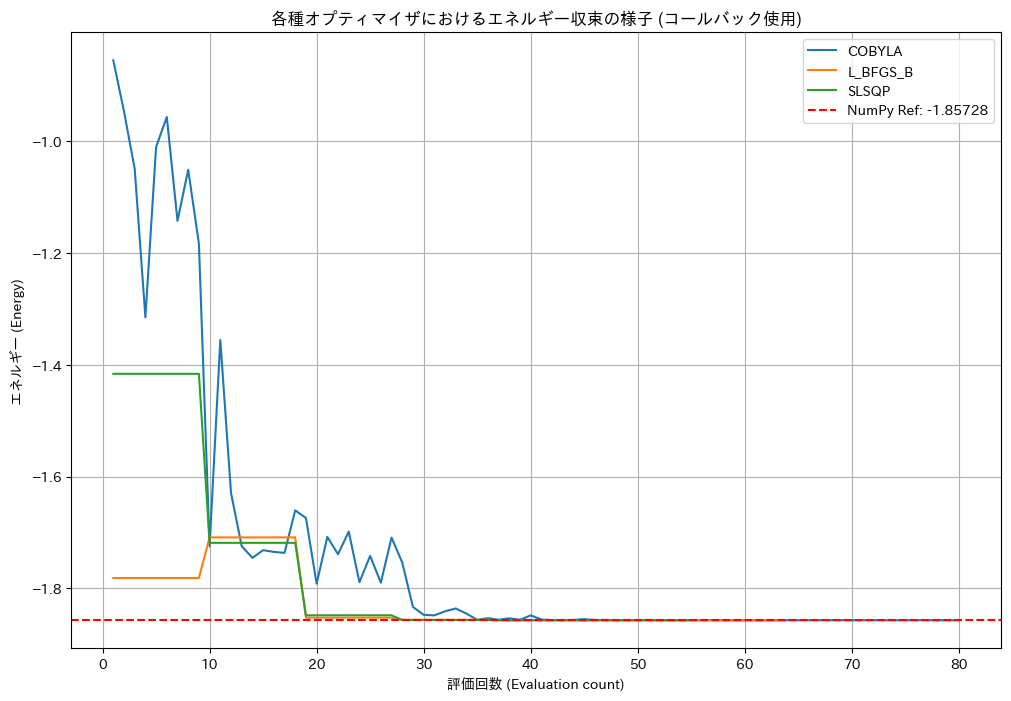

エネルギー収束のプロットを energy_convergence_callback.png に保存しました。
------------------------------



In [56]:
plt.figure(figsize=(12, 8))
for i, optimizer_name in enumerate(optimizer_names):
    plt.plot(converge_counts_list[i], converge_vals_list[i], label=optimizer_name)
# 厳密解を赤い破線でプロット
plt.axhline(y=ref_value, color='r', linestyle='--', label=f'NumPy Ref: {ref_value:.5f}')
plt.xlabel("評価回数 (Evaluation count)")
plt.ylabel("エネルギー (Energy)")
plt.title("各種オプティマイザにおけるエネルギー収束の様子 (コールバック使用)")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("energy_convergence_callback.png") # プロットをファイルに保存
plt.show() # Notebook内にプロットを表示
print("エネルギー収束のプロットを energy_convergence_callback.png に保存しました。")
print("-" * 30 + "\n")


### コールバックデータのプロット (参照値とのエネルギー差)
次に、VQEの解と厳密な参照値との差が、アルゴリズムが最小エネルギーに収束するにつれてどのように変化するかをプロットします。エネルギー差を対数スケールで表示することで、収束の終盤でのわずかな改善も視覚的に捉えやすくなります。

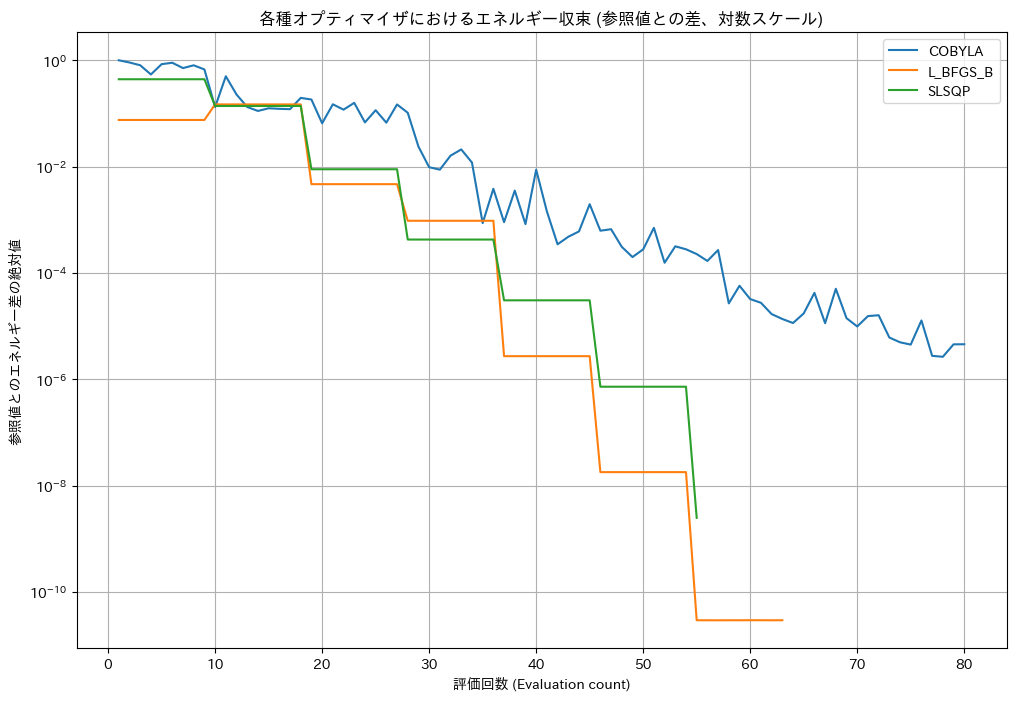

エネルギー差のプロットを energy_difference_log_callback.png に保存しました。
------------------------------



In [57]:
plt.figure(figsize=(12, 8))
for i, optimizer_name in enumerate(optimizer_names):
    # Y軸は (現在のエネルギー値 - 参照値) の絶対値
    plt.plot(
        converge_counts_list[i],
        np.abs(ref_value - converge_vals_list[i]),
        label=optimizer_name,
    )
plt.xlabel("評価回数 (Evaluation count)")
plt.ylabel("参照値とのエネルギー差の絶対値")
plt.title("各種オプティマイザにおけるエネルギー収束 (参照値との差、対数スケール)")
plt.yscale("log") # Y軸を対数スケールに
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("energy_difference_log_callback.png") # プロットをファイルに保存
plt.show() # Notebook内にプロットを表示
print("エネルギー差のプロットを energy_difference_log_callback.png に保存しました。")
print("-" * 30 + "\n")



### 4.2. カスタム勾配の使用
Qiskitの変分アルゴリズムでは、もし提供されたオプティマイザが勾配ベースの手法（例: L-BFGS-B, SLSQP）を使用する場合、デフォルトの勾配計算方法は有限差分法です（つまり、gradient パラメータが指定されない場合、アルゴリズム内部で有限差分法により勾配が計算されます）。
しかし、これらのクラスには gradient パラメータを介してカスタム勾配オブジェクトを渡すオプションが含まれています。これには、Qiskitの gradient フレームワーク内で提供される任意の方法（プリミティブの使用を完全にサポート）を使用できます。このセクションでは、VQEワークフローでカスタム勾配（この場合は FiniteDiffEstimatorGradient）を使用する方法を示します。

最初のステップは、対応するプリミティブ（Estimator）とプリミティブベースの勾配計算クラス（FiniteDiffEstimatorGradient）の両方を初期化することです。

In [58]:
print("--- 4.2. カスタム勾配の使用 ---")
# Estimatorは前のセルで定義済み (デフォルトの厳密なものを使用)

# FiniteDiffEstimatorGradientのインスタンス化
# このクラスは、与えられたEstimatorプリミティブを使用して、有限差分法により勾配を計算します。
# epsilonは、有限差分を計算する際の微小な摂動の大きさを指定します。
epsilon_val = 0.01
# qiskit_algorithms.gradients を使用
gradient_calculator = FiniteDiffEstimatorGradient(estimator, epsilon=epsilon_val)
print(f"勾配計算方法: {type(gradient_calculator).__name__} (epsilon={epsilon_val})")

# VQEのランダムな初期値選択の再現性のため
np.random.seed(50)

ansatz_grad = TwoLocal(num_qubits, rotation_blocks="ry", entanglement_blocks="cz")
# qiskit_algorithms.optimizers を使用。SLSQPは勾配情報を活用できるオプティマイザです。
optimizer_grad_slsqp = SLSQP(maxiter=100)

# コールバックデータの準備
counts_grad_cb = []
values_grad_cb = []
# qiskit_algorithms.VQE のコールバックは (eval_count, parameters, mean, stddev) の形式
def store_intermediate_result_grad_cb(eval_count, parameters, mean, stddev):
    counts_grad_cb.append(eval_count)
    values_grad_cb.append(mean)

# qiskit_algorithmsのVQEを使用し、gradientパラメータにgradient_calculatorを渡す
vqe_grad = VQE(estimator, ansatz_grad, optimizer_grad_slsqp,
               callback=store_intermediate_result_grad_cb, gradient=gradient_calculator)

print("\nVQE計算を実行中 (カスタム勾配使用)...")
result_grad = vqe_grad.compute_minimum_eigenvalue(operator=H2_op)
print("\nVQE計算結果 (カスタム勾配使用):")
print(f"  固有値 (エネルギー): {result_grad.eigenvalue.real:.8f}")
print(f"  コスト関数評価回数: {result_grad.cost_function_evals}") # 勾配計算のための評価も含まれる場合がある
print("-" * 30 + "\n")


--- 4.2. カスタム勾配の使用 ---
勾配計算方法: FiniteDiffEstimatorGradient (epsilon=0.01)

VQE計算を実行中 (カスタム勾配使用)...

VQE計算結果 (カスタム勾配使用):
  固有値 (エネルギー): -1.85727500
  コスト関数評価回数: 7
------------------------------



勾配使用時の収束プロット

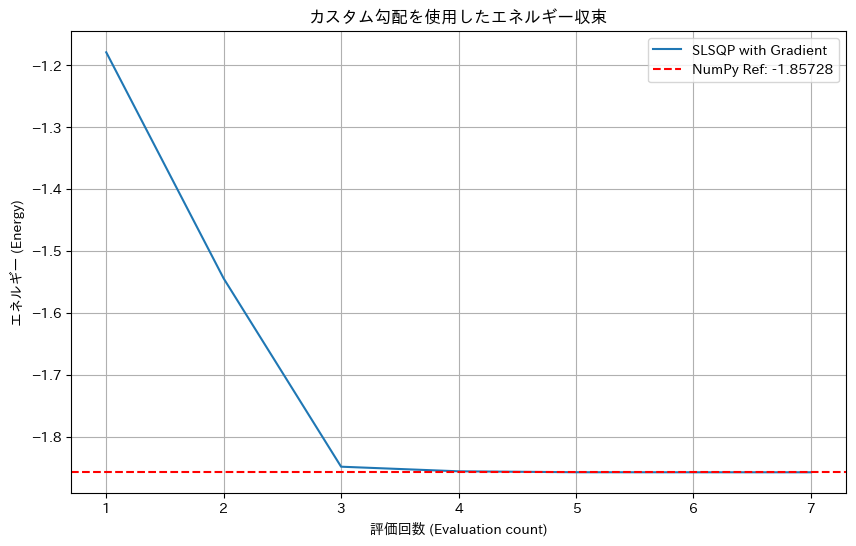

カスタム勾配使用時のエネルギー収束プロットを energy_convergence_gradient.png に保存しました。
------------------------------



In [59]:
plt.figure(figsize=(10, 6))
plt.plot(counts_grad_cb, values_grad_cb, label=f"{type(optimizer_grad_slsqp).__name__} with Gradient")
plt.axhline(y=ref_value, color='r', linestyle='--', label=f'NumPy Ref: {ref_value:.5f}') # ref_valueは前のセルで計算済み
plt.xlabel("評価回数 (Evaluation count)")
plt.ylabel("エネルギー (Energy)")
plt.title("カスタム勾配を使用したエネルギー収束")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("energy_convergence_gradient.png") # プロットをファイルに保存
plt.show() # Notebook内にプロットを表示
print("カスタム勾配使用時のエネルギー収束プロットを energy_convergence_gradient.png に保存しました。")
print("-" * 30 + "\n")



### 4.3. カスタム初期値 (Initial point) の使用
デフォルトでは、最適化はAnsatzによって定義された境界内のランダムな点（パラメータ値の組み合わせ）から開始されます。しかし、initial_point オプションを使用すると、この開始点を、Ansatzのパラメータ数に一致するカスタム値のリスト（NumPy配列など）で上書きできます。

なぜカスタム初期値を設定するのか？
このオプションは、以下のような場合に役立ちます。

問題に対する妥当な開始点の推測がある場合（例えば、より簡単な類似問題の解や物理的な洞察から）。

以前の実験から得られた情報（例えば、似たようなハミルトニアンに対する最適パラメータ）がある場合。

最適化アルゴリズムが局所解に陥りやすい場合に、異なる初期点から探索を開始させたい場合。

この機能を示すために、前のVQE実行（勾配計算あり）で得られた最適パラメータ (result_grad.optimal_point) を、次の計算の initial_point として使用してみましょう。

注意: initial_point は VQE クラスのキーワード専用引数です（つまり、initial_point=value のようにキーワードを指定して設定する必要があります）。

In [53]:
print("--- 4.3. カスタム初期値の使用 ---")
# 前の実行結果 (result_grad) の最適点を初期値として使用
# result_gradは前のセルで計算済みで、最適化されたパラメータのNumPy配列を保持しています。
initial_pt = result_grad.optimal_point
print(f"使用する初期パラメータ: {initial_pt}")

# Estimator, GradientCalculator は再利用
ansatz_init_pt = TwoLocal(num_qubits, rotation_blocks="ry", entanglement_blocks="cz")
# qiskit_algorithms.optimizers を使用
optimizer_init_pt_slsqp = SLSQP(maxiter=100) # オプティマイザも同様

# qiskit_algorithmsのVQEを使用し、initial_point パラメータを指定
vqe_init_pt = VQE(estimator, ansatz_init_pt, optimizer_init_pt_slsqp,
                  gradient=gradient_calculator, initial_point=initial_pt)

print("\nVQE計算を実行中 (カスタム初期値使用)...")
result_init_pt = vqe_init_pt.compute_minimum_eigenvalue(operator=H2_op)
print("\nVQE計算結果 (カスタム初期値使用):")
print(f"  固有値 (エネルギー): {result_init_pt.eigenvalue.real:.8f}")
# コスト関数評価回数に注目
print(f"  コスト関数評価回数: {result_init_pt.cost_function_evals} (初期値なしの場合: {result_grad.cost_function_evals})")
print("初期値を使用することで、評価回数が削減される（または既に最適解に近い場合は1回になる）ことが期待されます。")
print("-" * 30 + "\n")


--- 4.3. カスタム初期値の使用 ---
使用する初期パラメータ: [ 4.26344183  3.98081711  4.99322967 -1.44553584 -4.03510535  0.57859376
  5.65399529 -4.49233151]

VQE計算を実行中 (カスタム初期値使用)...

VQE計算結果 (カスタム初期値使用):
  固有値 (エネルギー): -1.85727486
  コスト関数評価回数: 1 (初期値なしの場合: 10)
初期値を使用することで、評価回数が削減される（または既に最適解に近い場合は1回になる）ことが期待されます。
------------------------------



cost_function_evals （コスト関数の評価回数）を見ると、初期値がアルゴリズムの収束を速めるのに役立ったことがわかります（この例では、既に最適解に近い点から開始したため、わずか1回の評価で収束しています）。

これは、2つの密接に関連する問題があり、一方の問題の解が他方の問題を推測するために使用できる場合に特に役立ちます。良い例としては、化学における分子の解離プロファイルのプロットがあります。そこでは、分子の原子間距離を少しずつ変化させ、各距離に対してその最小固有値（基底状態エネルギー）を計算します。距離の変化が小さい場合、新しい距離での解は以前の距離での解に近いと予想されます。したがって、一般的なテクニックは、ある距離での解の最適パラメータを、次の距離での計算の開始点として使用することです。
また、以前の解を直接使用するのではなく、複数の以前の解に基づいて外挿を行い、初期位置を計算する、より複雑なテクニックも存在します。